In [1]:
import os
import shutil
import pybedtools

import pandas as pd
import numpy as np
import itertools

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 100)

import statsmodels
import statsmodels.api as sm
import warnings

import seaborn as sns
import palettable
import matplotlib.pyplot as plt
from scripts import manuscript_colors as mc

from scripts import helper

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics, sv_plot

aesthetics.activate_paper_rcParams('illustrator')

# Targeted gene testing

In this notebook, we examine specific genes that have been implicated in the pathogenesis of these pediatric cancers. Essentially, this is a focused look to determine if SVs might affect these genes in cases vs. controls. The coding approach taken here is very high level, and it generates results for a predetermined list of disease-gene pairings. As a result, it can be a bit difficult to parse. The only part of the manuscript where these results are shown is in Figure S10.

This notebook also uses the language of "discovery" vs "validation" to refer to GMKF and St. Jude. This is an older approach to thinking about these datasets that is not used in the paper.

# Load the data

## Define paths to our data
We have 5 pieces of data.

Two of these files depends on whether we're analyzing the discovery or validation dataset:
1. Our SV file (in bed format)
2. Our dosage file (a dense matrix of SV genotypes)

Three files do not depend on this:

3. Our metadata files (which define which samples are cases, which are controls, etc)
4. Our list of genes (which defines which regions we analyze)
5. Our gene gtf (which defines the locations of our regions)

In [3]:
# define the folder name for all our results
folder_name = "targeted-genes"

# define SVs and dosages for discovery and validation
svs_discovery_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.4.case_control_cohort.analysis_samples.sites.bed.gz"
svs_validation_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.4.trio_cohort.analysis_samples.sites.bed.gz"

dosages_discovery_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.4.case_control_cohort.analysis_samples.allele_dosages.bed.gz"
dosages_validation_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.4.trio_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.4.cohort_metadata.w_control_assignments.tsv.gz"

discovery_samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.4.case_control_analysis_cohort.samples.list"
validation_samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.4.trio_analysis_cohort.samples.list"

# define which genes are tested
genes_to_test_path = "data/genes-for-analysis.csv"

# define reference for gene locations - GENCODE v43 (hg38)
gtf_path = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz"

# define the window size for our analysis (centered on the gene's center) - use 1 Mb
window_size = 1e6

In [4]:
genes_to_test = pd.read_csv(genes_to_test_path)
genes_to_test

,gene,transcript,disease
0,EWSR1,EWSR1-206,ewing
1,FLI1,FLI1-205,ewing
2,MYCN,MYCN-201,neuroblastoma
3,TERT,TERT-201,neuroblastoma
4,ALK,ALK-201,neuroblastoma
5,TP53,TP53-201,osteosarcoma
6,RB1,RB1-201,osteosarcoma
7,ATRX,ATRX-201,neuroblastoma
8,SHANK2,SHANK2-214,neuroblastoma
9,BRCA1,BRCA1-203,neuroblastoma


## Load the data into memory

First, load the SVs and dosages (takes a bit). We use a dictionary so we can simply refer to keys later (because discovery and validation are processed the same way downstream).

In [5]:
###############
##### SVs #####
###############
svs = {}

svs["discovery"] = pd.read_csv(
    svs_discovery_path,
    sep="\t",
)

svs["validation"] = pd.read_csv(
    svs_validation_path,
    sep="\t",
)
###############
### Dosages ###
###############
dosages = {}

dosages["discovery"] = pd.read_csv(
    dosages_discovery_path,
    sep="\t",
    index_col=False,
)

dosages["validation"] = pd.read_csv(
    dosages_validation_path,
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pedsv-test-conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,12,13,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/jettcrowdis/opt/anaconda3/envs/pedsv-test-conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (34,35,37,39,41,45,46,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302

Next we load metadata

In [6]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
samples = {}

samples["discovery"] = pd.read_csv(
    discovery_samples_path,
    header=None,
)[0].to_list()

samples["validation"] = pd.read_csv(
    validation_samples_path,
    header=None,
)[0].to_list()

And finally, load the gene data

In [7]:
genes_to_test = pd.read_csv(genes_to_test_path)

In [8]:
gtf = pd.read_csv(
    gtf_path,
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

## Make data folders

Here, we define folders that will contain all the data.

__Note: To avoid confusion, this code will erase any pre-existing runs with the same name. Use with caution.__

In [9]:
if os.path.isdir(f"data/{folder_name}"):
    shutil.rmtree(f"data/{folder_name}")

# make the data directory
os.mkdir(f"data/{folder_name}")

for index, row in genes_to_test.iterrows():
    g = row["gene"]
    disease = row["disease"]
    os.mkdir(f"data/{folder_name}/{g}-{disease}")

# Extract gene locations

Here, we extract from the gtf the locations of our genes.

In [10]:
gene_to_transcript = dict(genes_to_test[["gene", "transcript"]].values)

gene_locs = []
for index, row in genes_to_test.iterrows():
    g, t, disease = row.values

    # extract all elements of the gene and store them
    g_gtf = gtf[(gtf["attribute"].str.contains(f"transcript_name \"{t}\""))]
    g_gtf.to_csv(f"data/{folder_name}/{g}-{disease}/{g}-gtf.csv", index=False)
    
    # we also define the start and end of the gene here
    gene_loc = gtf[(gtf["attribute"].str.contains(f"gene_name \"{g}\"")) & (gtf['feature'] == 'gene')]
    assert len(gene_loc) == 1
    chrom, start, end = gene_loc[['seqname', 'start', 'end']].values[0]
    
    # store gene location
    gene_locs.append([g, chrom, start, end])
    
gene_locs = pd.DataFrame(gene_locs, columns = ['gene', 'chrom', 'start', 'end'])

# drop duplicates - happens with the same gene and different diseases
gene_locs = gene_locs.drop_duplicates()

# and expand the window according to our window size
gene_locs['window_start'] = (gene_locs['start'] - window_size / 2).astype(int)
gene_locs['window_end'] = (gene_locs['end'] + window_size / 2).astype(int)

# merge if we haven't already
if 'chrom' not in genes_to_test.columns:
    genes_to_test = genes_to_test.merge(gene_locs, on = 'gene')

In [11]:
genes_to_test.head(2)

,gene,transcript,disease,chrom,start,end,window_start,window_end
0,EWSR1,EWSR1-206,ewing,chr22,29268009,29300525,28768009,29800525
1,FLI1,FLI1-205,ewing,chr11,128686535,128813267,128186535,129313267


In [12]:
genes_to_test.to_csv(f'data/{folder_name}/gene-locations.csv', index=False)

# Define the SVs of interest for each analysis

Doing this is somewhat complicated, as we need to juggle both discovery and validation cohorts. We do the following:

1. Define the cases and controls for the analysis based on the disease type
2. Define the genomic region of interest, based on the gene data defined above
3. Subset the SVs down to SVs in this region
4. Subset the dosage down to those SVs and the samples of interest

We use a kind of round-about disease-based approach because then we only need to make three copies of large dataframes.

In [13]:
for disease in ['ewing', 'osteosarcoma', 'neuroblastoma']:
    
    # define the number of genes we're looking at in this disease
    disease_genes = genes_to_test[genes_to_test['disease'] == disease]
    if len(disease_genes) == 0:
        continue
    
    # we subset discovery and validation datasets to relevant samples and SVs
    for cohort in ["discovery", "validation"]:
        print(disease, cohort)
        
        # osteosarcoma has no validation datasets, so we skip
        if disease == 'osteosarcoma' and cohort == 'validation':
            continue
        
        ########################
        #### DEFINE SAMPLES ####
        ########################
        
        # this term for cohort is used in the metadata
        study_label = "case_control" if cohort == "discovery" else "trio"

        # define the samples
        cohort_samples = samples[cohort]

        # get the cases - must belong to disease, must be right cohort, and must be a case included for analysis
        cases = metadata[
            (metadata["study_phase"] == study_label)
            & (metadata[f"{disease}_case"])
        ]["entity:sample_id"].to_list()
        cases = sorted(set(cohort_samples) & set(cases))

        # get the controls - must be a control, right cohort, and a control for that analysis
        controls = metadata[
            (metadata["study_phase"] == study_label)
            & (metadata[f"{disease}_control"])
        ]["entity:sample_id"].to_list()
        controls = sorted(set(cohort_samples) & set(controls))

        # some quick checks
        assert set(cases) & set(controls) == set()
        
        ################################
        #### DEFINE SVS AND DOSAGES ####
        ################################
        
        # fetch our cohort data (discovery or validation)
        cohort_svs = svs[cohort].copy()
        cohort_dosages = dosages[cohort].copy()
        
        # subset the dosage matrix down to the cases and controls for our disease
        cohort_dosages = cohort_dosages[['#chr', 'start', 'end', 'ID'] + cases + controls].copy()
        
        # drop any SVs that have no alternative genotypes in these samples (i.e. aren't present)
        cohort_sv_counts = cohort_dosages.iloc[:, 4:].fillna(0).sum(axis = 1)

        # subset down SVs and dosages to just SVs with nonzero dosages
        cohort_svs = cohort_svs[cohort_sv_counts != 0]
        cohort_dosages = cohort_dosages[cohort_sv_counts != 0]
        
        #########################################
        #### SUBSET SVS and DOSAGES TO GENES ####
        #########################################
        gene_locs = disease_genes[['chrom', 'window_start', 'window_end', 'gene']]
        
        # bedtools expects specific column names and ordering
        gene_locs.columns = ['chrom', 'start', 'end', 'gene']
        
        # create bedtools object for our genes
        gene_bed = pybedtools.BedTool(
            gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
        )
        
        # create bedtool object for svs
        sv_bed = pybedtools.BedTool(
            cohort_svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
            from_string=True,
        )

        svs_in_regions = sv_bed.intersect(gene_bed, wo=True)
        svs_in_regions = svs_in_regions.to_dataframe()

        # drop unnecessary columns
        svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
        svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
        
        ############################
        #### ADD IN COMPLEX SVS ####
        ############################
        
        # This step is not completely necessary, but I include it for completeness.
        # The idea is that basing our SVs on strict overlap isn't good enough--some SVs
        # may involve in the region as part of a complex rearrangement.
        cohort_complex_svs = cohort_svs[(cohort_svs["svtype"] == "CPX")][
                                    [
                                        "name",
                                        "#chrom",
                                        "start",
                                        "end",
                                        "svtype",
                                        "CHR2",
                                        "CPX_INTERVALS",
                                        "CPX_TYPE",
                                        "END",
                                    ]
                                ].copy()
        
        # split each component SV--represented by CPX_INTERVALS--into their own rows
        cohort_complex_svs = cohort_complex_svs.assign(
            intervals=cohort_complex_svs["CPX_INTERVALS"].str.split(",")
        ).explode("intervals")

        # convert this data to a proper bed for intersection
        cohort_complex_sv_bed = cohort_complex_svs[["name", "intervals"]].copy()
        cohort_complex_sv_bed["chrom"] = cohort_complex_sv_bed["intervals"].apply(
            lambda interv: interv.split(":")[0].split("_")[-1]
        )
        cohort_complex_sv_bed["start"] = cohort_complex_sv_bed["intervals"].apply(
            lambda interv: interv.split(":")[-1].split("-")[0]
        )
        cohort_complex_sv_bed["end"] = cohort_complex_sv_bed["intervals"].apply(
            lambda interv: interv.split(":")[-1].split("-")[1]
        )

        # convert to a bedtool
        cohort_complex_sv_bed = pybedtools.BedTool(
            cohort_complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
                sep="\t", index=False, header=False
            ),
            from_string=True,
        )

        # do our intersection
        complex_svs_in_regions = cohort_complex_sv_bed.intersect(gene_bed, wo=True)
        complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

        # drop unnecessary columns
        if len(complex_svs_in_regions):
            complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
            complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
        else:
            complex_svs_in_regions = pd.DataFrame(
                columns=["chrom", "start", "end", "name", "gene"]
            )
        
        ######################################################
        #### DEFINE AND FILTER OUR SVS IN THESE REGIONS ######
        ######################################################
        
        # combine normal and complex SVs together
        svs_in_regions_names = pd.concat(
            [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
        )

        # drop duplicates (only happens if an SV is simple but also part of a complex SV)
        svs_in_regions_names = svs_in_regions_names.drop_duplicates(subset = ['name'])
        
        # subset SVs
        subset_svs = cohort_svs.set_index("name").loc[svs_in_regions_names["name"]].reset_index()
        subset_svs.insert(0, "gene", svs_in_regions_names["gene"].values)

        # convert AF to float. We extract an AF for CNVs as well
        subset_svs['AF'] = subset_svs.apply(lambda row: float(row['AF']) if row['svtype'] != 'CNV' else row['CN_NONREF_FREQ'], axis = 1)

        # only include SVs that pass the FILTER and are in our dosage matrix
        svs_to_keep = subset_svs[
            (
                (subset_svs["FILTER"].isin(["PASS", "MULTIALLELIC"]))
                & (subset_svs["name"].isin(cohort_dosages["ID"].to_list()))
            )
        ].copy()

        svs_to_keep["rare"] = svs_to_keep["AF"] < 0.01
        
        # subset dosage matrix
        subset_dosages = cohort_dosages.set_index('ID').loc[svs_to_keep["name"].to_list()].reset_index()

        # we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
        subsetted_gene_dosages = (
            svs_to_keep[["name", "gene", "AF", "rare"]]
            .merge(subset_dosages, right_on="ID", left_on="name")
            .drop(columns = ['ID'])
        )

        #########################
        #### EXPORT OUR DATA ####
        #########################
        
        # extract cohort metadata
        cohort_metadata = metadata[metadata['entity:sample_id'].isin(cases + controls)]
        
        # we export everything to reconstruct whatever analyses we want.
        for g in gene_locs['gene']:
            
            export_prefix = f'data/{folder_name}/'

            # export sample info
            cohort_metadata.to_csv(export_prefix + f'{g}-{disease}/{cohort}-metadata.csv', index=False)
            
            gene_svs = svs_to_keep[svs_to_keep['gene'] == g]
            gene_dosages = subsetted_gene_dosages[subsetted_gene_dosages['gene'] == g]
            
            gene_svs.to_csv(export_prefix + f'{g}-{disease}/{cohort}-svs.csv', index=False)
            gene_dosages.to_csv(export_prefix + f'{g}-{disease}/{cohort}-dosages.csv', index=False)

ewing discovery
ewing validation
osteosarcoma discovery
osteosarcoma validation
neuroblastoma discovery
neuroblastoma validation


# Calculate allele fractions

While we could have done this above, I think it's worth separating this out for compartmentalization.

We devise two metrics for cases and controls--one listing the allele frequency of each SV and another listing the number of samples with an SV in the gene. We need to convert the dosage (allele count) to allele frequencies

In [14]:
for index, row in genes_to_test.iterrows():
    gene, disease = row[['gene', 'disease']].values
    print(gene, disease)
    
    file_prefix = f'data/{folder_name}/{gene}-{disease}/'
    for cohort in ['discovery', 'validation']:

        # osteosarcoma has no validation datasets, so we skip
        if disease == 'osteosarcoma' and cohort == 'validation':
            continue
    
        ######################
        #### READ IN DATA ####
        ######################
        analysis_dosages = pd.read_csv(file_prefix + f'{cohort}-dosages.csv')
        analysis_svs = pd.read_csv(file_prefix + f'{cohort}-svs.csv')
        analysis_metadata = pd.read_csv(file_prefix + f'{cohort}-metadata.csv')

        # get the cases and controls
        analysis_cases = analysis_metadata.query(f'disease == "{disease}"')['entity:sample_id'].to_list()
        analysis_controls = analysis_metadata.query(f'disease == "control"')['entity:sample_id'].to_list()
        
        ###########################
        #### EXTRACT SV COUNTS ####
        ###########################
        
        case_control_counts = []
        case_control_samples_with_svs = []

        for sample_group, label in zip(
            [analysis_cases, analysis_controls], ["cases", "controls"]
        ):

            # subset to these samples
            sample_dosages = analysis_dosages[
                ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
            ]

            # first, count the SVs. This function counts the number of samples with each genotype.
            sv_counts = (
                analysis_dosages[sample_group]
                .apply(lambda row: row.dropna().value_counts(), axis=1)
                .fillna(0)
                .astype(int)
            )

            # name columns to genotypes
            sv_counts.columns = f"{label}_" + sv_counts.columns.astype(int).astype(str)
            sv_counts["name"] = sample_dosages["name"]

            case_control_counts.append(sv_counts)

            # now count the number of samples with at least one SV around each gene.
            # we groupby gene, then determine whether each sample has an SV in that gene, then
            # count these samples up per gene.
            num_samples_with_svs = sample_dosages.groupby(["gene"]).apply(
                lambda group: (group[sample_group] > 0).any(axis=0).sum()
            )

            num_samples_with_svs.name = label + "_all"
            num_samples_with_svs = num_samples_with_svs / len(sample_group)
            case_control_samples_with_svs.append(num_samples_with_svs)

            # repeat for rare SVs
            num_samples_with_svs_rare = (
                sample_dosages.query("rare == True")
                .groupby(["gene"])
                .apply(lambda group: (group[sample_group] > 0).any(axis=0).sum())
            )

            num_samples_with_svs_rare.name = label + "_rare"
            num_samples_with_svs_rare = num_samples_with_svs_rare / len(sample_group)
            case_control_samples_with_svs.append(num_samples_with_svs_rare)

        # merge cases and controls together
        case_control_sv_counts = sample_dosages.iloc[:, :7].reset_index(drop=True)
        for df in case_control_counts:
            case_control_sv_counts = case_control_sv_counts.merge(df)

        case_control_sv_counts["midpoint"] = np.mean(
            case_control_sv_counts[["start", "end"]], axis=1
        )

        # and total up the sample counts
        case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T
        
        ######################################
        #### CALCULATE ALLELE FREQUENCIES ####
        ######################################
        
        # Remove CNVs and calculate separately if present
        if case_control_sv_counts['name'].str.contains('_CNV_').sum() > 0:
            cnv_counts = case_control_sv_counts[case_control_sv_counts['name'].str.contains('CNV')].copy()
            
            for label in ['cases', 'controls']:
                columns = [col for col in cnv_counts.columns if col.startswith(label)]
                genotypes = [int(c.split('_')[-1]) for c in columns]
                alleles = (cnv_counts[columns] * np.array(genotypes))
                average_cn = alleles.sum(axis = 1) / cnv_counts[columns].sum(axis = 1)

                # overwrite the value with cases and controls
                cnv_counts[f'average_CN_{label}'] = average_cn
            
            # export
            cnv_counts.to_csv(file_prefix + f'{cohort}-cnv-genotypes.csv', index=False)
        
            # and remove any trace of CNVs from our genotypes
            cnv_columns = [c for c in case_control_sv_counts.columns if '_' in c and c.split('_')[-1] not in ['0', '1', '2']]
            case_control_sv_counts = case_control_sv_counts.drop(index = cnv_counts.index, columns = cnv_columns).reset_index(drop = True)
            
        # now we do our SVs. We calculate their allele fraction
        for label in ["cases", "controls"]:

            # a quick check to see if there are non-0/1/2 genotypes
            columns = [col for col in case_control_sv_counts.columns if col.startswith(label)]
            assert columns == [f"{label}_{i}" for i in range(3)]

            alt = (case_control_sv_counts[columns] * np.array([0, 1, 2])).sum(axis=1)
            ref = case_control_sv_counts[columns].sum(axis=1) * 2
            case_control_sv_counts[f"AF_{label}"] = alt / ref
            
        # export
        case_control_sv_counts.to_csv(file_prefix + f'{cohort}-sv-genotypes.csv', index=False)

EWSR1 ewing
FLI1 ewing
MYCN neuroblastoma
TERT neuroblastoma
ALK neuroblastoma
TP53 osteosarcoma
TP53 neuroblastoma
TP53 ewing
RB1 osteosarcoma
ATRX neuroblastoma
SHANK2 neuroblastoma
BRCA1 neuroblastoma
CDKN2A ewing
DLG2 osteosarcoma


# Calculate associations

Up next, we'll calculate the different statistical tests, e.g. individual SV tests and burden testing.

We begin by doing burden testing. We do it in a few different ways:

1. `logit(case_status) ~ count_of_rare/common_SVs + ancestry_PCs + sex`
2. `logit(case_status) ~ count_of_rare/common_SVs + sex`
3. `logit(case_status) ~ count_of_rare/common_SVs`

We store these all in the same file, and we calculate for both discovery and validation. In the analysis without ancestry, we subset to individuals of predominantly European ancestry.

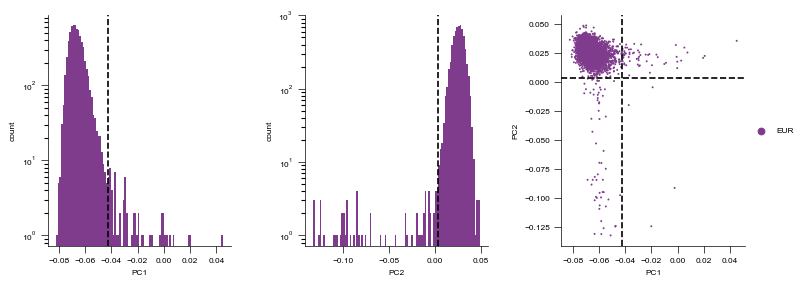

In [15]:
# select european samples
fig, axes = plt.subplots(1, 3, figsize = (9, 3), gridspec_kw = {'wspace': 0.4})

euro_samples = metadata.query('ancestry_inferred_by_SVs == "EUR"')
euro_metadata = metadata.copy()

cutoffs = []
for i, comp in enumerate(['PC1', 'PC2']):
    
    # determine cutoffs
    skew = euro_samples[comp].mean() - euro_samples[comp].median()
    
    # if left skewed, use 2.5% percentile
    if skew < 0:
        cut = np.percentile(euro_samples[comp], [1])[0]
        euro_metadata = euro_metadata[euro_metadata[comp] > cut]
        
    else:
        cut = np.percentile(euro_samples[comp], [99])[0]
        euro_metadata = euro_metadata[euro_metadata[comp] < cut]
        
    cutoffs.append(cut)
    
    axes[i].hist(metadata.query('ancestry_inferred_by_SVs == "EUR"')[comp], bins = 100);
    axes[i].set_yscale('log')
    aesthetics.strip_axis(ax = axes[i], x = 'ignore', y = 'ignore')
    axes[i].set_ylabel('count')
    axes[i].set_xlabel(comp)
    
    # add cutoff
    axes[i].axvline(x = cut, color = 'black', linestyle = 'dashed')
    
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'ancestry_inferred_by_SVs', ax = axes[2], data = euro_samples, s = 2, ec = None)
axes[2].axhline(cutoffs[1], color = 'black', linestyle = 'dashed')
axes[2].axvline(cutoffs[0], color = 'black', linestyle = 'dashed')
sns.despine(ax = axes[2])
axes[2].legend(bbox_to_anchor = (1, 0.5))

fig.savefig(f'data/{folder_name}/european-samples.png')

In [16]:
print(metadata.shape[0], 'total samples')
print(euro_metadata.shape[0], 'European samples')

10590 total samples
6346 European samples


In [17]:
# here, we define the models that will be run
covariates = {'no-covariates': [],
              'sex': ["sex"],
              'sex-ancestry': ['sex', 'PC1', 'PC2', 'PC3']}

# any analysis without ancestry must be subset to european samples
euro_samples = euro_metadata['entity:sample_id'].to_list()

In the following code block, we run our association tests.

In [18]:
for index, row in genes_to_test.iterrows():
    gene, disease = row[['gene', 'disease']].values
    print(gene, disease)
    
    file_prefix = f'data/{folder_name}/{gene}-{disease}/'
    
    gene_disease_results = []
    for cohort in ['discovery', 'validation']:

        # osteosarcoma has no validation datasets, so we skip
        if disease == 'osteosarcoma' and cohort == 'validation':
            continue
            
        #######################
        #### LOAD OUR DATA ####
        #######################
        
        analysis_dosages = pd.read_csv(file_prefix + f'{cohort}-dosages.csv')
        analysis_metadata = pd.read_csv(file_prefix + f'{cohort}-metadata.csv')

        # get the cases and controls
        analysis_cases = analysis_metadata.query(f'disease == "{disease}"')['entity:sample_id'].to_list()
        analysis_controls = analysis_metadata.query(f'disease == "control"')['entity:sample_id'].to_list()
        
        # note that we have to drop CNVs here (their AFs are inaccurate)
        analysis_dosages = analysis_dosages[~analysis_dosages['name'].str.contains('_CNV_')]
        
        # load the model data. We next add dosages and burdens to this data.
        model_data = metadata.set_index('entity:sample_id').loc[analysis_cases + analysis_controls]
        model_data["disease"] = model_data["disease"].replace({disease: 1, "control": 0})
        
        # keep track of all our analyses
        exog_cols = []
        
        ########################
        #### ADD SV DOSAGES ####
        ########################
        
        # define an n x m matrix, where n is sv, m is sample, and element is dosage
        temp_dosages = analysis_dosages.set_index("name")[analysis_cases + analysis_controls]
        model_data.loc[temp_dosages.columns, list(temp_dosages.index)] = temp_dosages.T
        
        # all these SVs are analyzed independently
        exog_cols += list(temp_dosages.index)
        
        #######################
        #### ADD SV BURDEN ####
        #######################
        
        # add three columns to model data: rare, common, and combined
        # these describe how many of each SV is present in that sample around this gene
        for rare in [True, False]:

            # define a label for the analysis
            label = {True: 'rare-burden', False: 'common-burden'}[rare]
            exog_cols.append(label)
            
            # subset to rare or common variants
            subanalysis_dosages = analysis_dosages[analysis_dosages['rare'] == rare]

            # count the number of samples with at least one non-ref allele
            sv_counts = (subanalysis_dosages[analysis_cases + analysis_controls] > 0).sum(axis=0)

            model_data.loc[sv_counts.index, label] = sv_counts.astype(int)
            
        # add rare + common burden
        model_data['combined-burden'] = model_data['rare-burden'] + model_data['common-burden']
        exog_cols.append('combined-burden')
        
        # we also try a one-hot encoding
        for col in ['rare-burden', 'common-burden', 'combined-burden']:
            onehot_col = col + '-onehot'
            model_data[onehot_col] = (model_data[col] > 0).astype(int)
            exog_cols.append(onehot_col)
            
        model_data.reset_index().to_csv(file_prefix + f'{cohort}-model-data.csv', index=False)

        ####################
        #### RUN MODELS ####
        ####################
        
        # store model results
        modeling_results = []
        
        # for each set of covariates, run all our models
        for covar_label, covar in covariates.items():
            
            # if ancestry isn't included as a covariate, we subset to euro samples
            if 'ancestry' not in covar_label:
                parent_covar_data = model_data.loc[set(model_data.index) & set(euro_samples)].copy()
            else:
                parent_covar_data = model_data.copy()
            
            # Run each SV and burden analysis
            for col in exog_cols:
                
                analysis_type = 'burden' if 'burden' in col else 'sv'
                
                # define data
                submodel_data = parent_covar_data[['disease', col] + covar]
                
                # we drop samples that aren't defined for our variable of interest
                # this is usually SVs that can't be genotyped
                submodel_data_nonna = submodel_data.dropna(subset=[col]).copy()
                
                # this has the potential to introduce bias, so we quantify what was dropped
                old_counts = submodel_data['disease'].value_counts().loc[[0, 1]]
                new_counts = submodel_data_nonna['disease'].value_counts().loc[[0, 1]]
                dropped = old_counts - new_counts
                
                # define x and y for the model
                Y = submodel_data_nonna["disease"]
                x = sm.tools.add_constant(submodel_data_nonna, has_constant = 'add')
                x = x.drop(columns = ['disease'])
                
                # suppress some warnings
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    logit_model = sm.Logit(
                    Y,
                    x,
                    ).fit(disp=0, method="bfgs", maxiter=1000)
                
                # store model results as a row
                row = [analysis_type, covar_label, col, dropped.loc[0], dropped.loc[1]]
                
                # extract p and coeff (change coef to nan if p is nan)
                # this happens whenever the model is singular
                p = logit_model.pvalues.loc[col]
                coef = logit_model.params.loc[col] if not np.isnan(p) else np.nan

                row += [coef, p]
                    
                modeling_results.append(row)
        
        # combine into one dataframe
        modeling_results = pd.DataFrame(modeling_results, columns = ['type', 'covar', 'model', 'controls_dropped', 'cases_dropped', 'coef', 'p'])
    
        ################################
        #### BONFERRONI CORRECT SVS ####
        ################################
        if cohort == 'discovery':
            for covar_label in covariates.keys():

                covar_results = modeling_results[(modeling_results['type'] == 'sv') & 
                                                 (modeling_results['covar'] == covar_label)
                                                ]

                pvals = covar_results['p']
                p_bonferroni = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='bonferroni')[1]

                modeling_results.loc[covar_results.index, 'p_bonferroni'] = p_bonferroni
        
        ################
        #### EXPORT ####
        ################

        modeling_results.to_csv(file_prefix + f'{cohort}-model-results.csv', index=False)
    
    ####################################
    #### DEFINE SIGNIFICANT RESULTS ####
    ####################################
    
    discovery = pd.read_csv(file_prefix + 'discovery-model-results.csv')
    
    if disease == 'osteosarcoma':
        cohorts = [discovery]
    else:
        validation = pd.read_csv(file_prefix + 'validation-model-results.csv')
        cohorts = [discovery, validation]
        
    # subset results in each cohort down to those that are significant
    sig_results = []
    for i, cohort in enumerate(cohorts):
        cohort_sig_results = []
        
        for index, row in cohort.iterrows():
            
            # define our p value cutoff
            if i == 0 and row['type'] == 'sv':
                p_col = 'p_bonferroni'
            else:
                p_col = 'p'
            
            if row[p_col] < 0.05:
                cohort_sig_results.append(index)
            # get all models, which use different covariates
                
        # subset the cohort to these results
        cohort = cohort.loc[cohort_sig_results]
        
        sig_results.append(cohort)
    
    # combine results
    if len(cohorts) == 1:
        sig_results = sig_results[0].copy()
    else:
        sig_results = sig_results[0].merge(sig_results[1], on = ['type', 'covar', 'model'], 
                                           suffixes = ['_discovery', '_validation'], how = 'inner')

    if len(sig_results):
        sig_results.to_csv(file_prefix + 'significant-results.csv', index=False)
    

EWSR1 ewing
FLI1 ewing
MYCN neuroblastoma
TERT neuroblastoma
ALK neuroblastoma
TP53 osteosarcoma
TP53 neuroblastoma
TP53 ewing
RB1 osteosarcoma
ATRX neuroblastoma
SHANK2 neuroblastoma
BRCA1 neuroblastoma
CDKN2A ewing
DLG2 osteosarcoma


# Plot results

Here, we define and make some plots for visual inspection. We visualize ~1 Mb around the gene of interest and plot all SVs, denoting which ones were significant in our association testing.

In [19]:
sv_colors = {"DEL": "blue", "DUP": "red", "INS": bold_10[0]}

In [20]:
for index, row in genes_to_test.iterrows():
    gene, disease = row[['gene', 'disease']].values
    
    file_prefix = f'data/{folder_name}/{gene}-{disease}/'
    
    # plot discovery and validation, split by common and rare on same plot
    num_plots = 2 if disease == 'osteosarcoma' else 4
    gene_fig, gene_axes = plt.subplots(num_plots, 1, figsize=(7, num_plots), gridspec_kw = {'hspace': 0.5})
    
    # figure for gene burden
    burden_fig, burden_axes = plt.subplots(num_plots, 1, figsize=(6, num_plots * 3), gridspec_kw = {'hspace': 0.5})
    
    plot_num = 0
    for sv_type, cohort in itertools.product(['common', 'rare'], ['discovery', 'validation']):

        # osteosarcoma has no validation datasets, so we skip
        if disease == 'osteosarcoma' and cohort == 'validation':
            continue
            
        #######################
        #### LOAD OUR DATA ####
        #######################
        
        # load counts, and subset to rare or common
        analysis_counts = pd.read_csv(file_prefix + f"{cohort}-sv-genotypes.csv")
        analysis_counts = analysis_counts[analysis_counts['rare'] == (sv_type == "rare")].reset_index()
        
        # load model data, strictly for burden testing
        model_data = pd.read_csv(file_prefix + f"{cohort}-model-data.csv")

        # significance results - based on the model with both sex and ancestry
        model_results = pd.read_csv(file_prefix + f"{cohort}-model-results.csv")
        model_results = model_results.query('covar == "sex-ancestry"').set_index("model")
        
        # gene-related data
        g_gtf = pd.read_csv(file_prefix + f"{gene}-gtf.csv")
        
        ########################
        #### PLOT SV BURDEN ####
        ########################
        ax = burden_axes[plot_num]

        max_count = 0
        for label in ['cases', 'controls']:
            ind = label == "cases"
            data = model_data.query(f"disease == {ind}")[f"{sv_type}-burden"].value_counts()
            
            if max(data.index) > max_count:
                max_count = max(data.index)

            for i in range(max(data.index)):
                if i not in data.index:
                    data.loc[i] = 0

            data = data.sort_index()
            data = data / data.sum()

            base = -0.2 if label == 'cases' else 0.2
            x = np.arange(base, max(data.index) + 1 + base, 1)

            ax.bar(x=x, height=data, width=0.4, label=label)

        aesthetics.strip_axis(ax=ax, x='label', y = 'ignore')
        
        if plot_num == 1:
            ax.legend(bbox_to_anchor = (1, 0))

        ax.set_xlabel('SV count')
        ax.set_ylabel('Density')
        cohort_name = 'GMKF' if cohort == 'discovery' else 'St. Jude'
        ax.text(x = 0.5, y = 1.05, s = f'{cohort_name} SVs', 
                transform = ax.transAxes, ha = 'center', va = 'bottom')
        ax.set_xticks(range(max_count + 1))
        
        if sv_type == 'rare':
            ax.set_yscale('log')
            
        # add p value
        coef, p = model_results.loc[f'{sv_type}-burden', ['coef', 'p']].values
        s = f"β = {round(coef, 2)}\np = {p:.2}"
        ax.text(x = 1, y = 0.9, s = s, 
                transform = ax.transAxes, ha = 'right', va = 'top')
        
        #######################
        #### PLOT THE GENE ####
        #######################
        ax = gene_axes[plot_num]
        gene_data = genes_to_test[(genes_to_test['gene'] == gene) &
                                  (genes_to_test['disease'] == disease)].iloc[0]
        
        # we weirdly have to do this now because the code that plots
        # the genes does so with relative sizes
        ylim = [-0.02, 0.02] if sv_type == 'rare' else [-1, 1]
        yticks = [-0.02, 0, 0.02] if sv_type == 'rare' else [-1, 0, 1]

        # plot the genetic elements
        color = {'neuroblastoma': mc.palette['neuroblastoma']['main'], 'ewing': mc.palette['ewing']['main'], 'osteosarcoma': mc.palette['osteosarcoma']['main']}[disease]
        feature_colors = {"exon": color, "CDS": color}
        window = gene_data.loc[['window_start', 'window_end']].values
        feature_span = {"exon": ylim[-1] / 4, "CDS": ylim[-1] / 2}

        # custom code that plots a genomic element
        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        # plot the range of interest
        ax.set_xlim(
            window + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(window)

        # add labels
        ax.text(s="cases", x=-0.03, y=0.75, transform=ax.transAxes, ha="right", va='center')
        ax.text(s="controls", x=-0.03, y=0.25, transform=ax.transAxes, ha="right", va='center')
        ax.set_ylabel('AF', labelpad = 15)

        # switch to Mb
        contig = gene_data.loc["chrom"]
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")
        
        ax.set_yticks(yticks)
        ax.set_yticklabels(np.abs(yticks))
        ax.set_ylim(ylim)
        
        # add title for gene
        # ax.text(x = gene_data.loc[['start', 'end']].mean(), y = ylim[-1], s = gene, 
        #         fontstyle = 'italic', ha = 'center', fontsize = 8)
        
        # label for plot
        cohort_name = 'GMKF' if cohort == 'discovery' else 'St. Jude'
        ax.text(x = 0.01, y = 1, s = f'{cohort_name} SVs', transform = ax.transAxes, ha = 'left')
        
        ######################
        #### PLOT THE SVS ####
        ######################
        # its much easier to plot everything at once with plt.stem, but that function is poor
        # so we do it manually. We scale the frequency to fill the plot
        case_y = analysis_counts['AF_cases']
        control_y = analysis_counts['AF_controls']

        # add the points
        ax.scatter(x=analysis_counts["midpoint"], y=case_y, color="black", s=3, zorder=3)
        ax.scatter(x=analysis_counts["midpoint"], y=-control_y, color="black", s=3, zorder=3)
        
        ################################
        #### DENOTE SIGNIFICANT SVS ####
        ################################
        
        # add the line denoting the SV
        legend_handles = {}
        for i in range(len(analysis_counts)):
            
            loc = analysis_counts["midpoint"][i]
            
            # sometimes SVs are shown that are way outside the boundaries
            if not (window[0] <= loc <= window[1]):
                continue
            
            name = analysis_counts["name"][i]

            case, control = case_y[i], control_y[i]

            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )
            
            # look up the p value of the sv, if it exists
            if name in model_results.index:
                p_col = 'p_bonferroni' if cohort == 'discovery' else "p"
                p_val, coeff = model_results.loc[name, [p_col, "coef"]]

                if p_val < 0.05:

                    y = case if coeff > 0 else -control
                    text_y = y + 0.3 * ylim[-1] if coeff > 0 else y - 0.3 * ylim[-1]

                    sv_type = name.split('_')[1]
                    color = sv_colors.get(sv_type)

                    scatter = ax.scatter(
                        [loc], [y], color=color, s=10, zorder=3, label=sv_type
                    )

                    legend_handles[sv_type] = scatter

                    # add text for coeff
                    ax.text(
                        x=loc,
                        y=text_y,
                        s=f"β = {round(coeff, 2)}, p = {p_val:.1}",
                        ha="center",
                        va="center",
                    )
        
        plot_num += 1
        
    gene_fig.savefig(file_prefix + 'sv-plot.pdf')
    plt.close(gene_fig)
    
    burden_fig.savefig(file_prefix + 'sv-burden.png')
    plt.close(burden_fig)

/Users/jettcrowdis/opt/anaconda3/envs/pedsv-test-conda/lib/python3.7/site-packages/ipykernel_launcher.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator


Note that while several of these figures depict common SVs (AF > 5%) that appear plausible, these have been individually reviewed and can all be explained by either technical factors.

# Quality control

Here, we briefly extract some QC metrics for our "significant" SVs, and we also batch these SVs together. This allows us to manually review QC metrics for SVs that are deemed to be significant.

In [21]:
qc_cols = [line.strip() for line in open('data/qc-columns-order.txt')]

sv_cols = ['name', 'svtype', 'ALGORITHMS', 'EVIDENCE', 'SL_MEAN', 'SL_MAX', 'NCR', 'HG38_REF_PATCH_LOCUS']
sv_cols += [c for c in svs['discovery'].columns if c.startswith('gnomad') and '_CN_' not in c]

ucsc_tracks = ["simpleRepeat", "genomicSuperDups", "rmsk", "microsat"]

df_cols = qc_cols + sv_cols + ucsc_tracks

In [22]:
significant_results_qc = []
for index, row in genes_to_test.iterrows():
    gene, disease = row[['gene', 'disease']].values
    
    file_prefix = f'data/{folder_name}/{gene}-{disease}/'
    
    ######################
    #### READ IN DATA ####
    ######################
    
    # begin by loading the significant results
    if os.path.exists(file_prefix + 'significant-results.csv'):
        significant_results = pd.read_csv(file_prefix + 'significant-results.csv')
    else:
        continue
        
    significant_svs = significant_results.query('type == "sv" & covar == "sex-ancestry"')['model'].to_list()

    if len(significant_svs) == 0:
        continue
    
    #################################################
    #### COMBINE SV GENOTYPES WITH MODEL RESULTS ####
    #################################################
    
    # we load in discovery and validation separately, to better enable side by side comparison
    cohort_significant_results = []
    for cohort in ['discovery', 'validation']:
        if disease == 'osteosarcoma' and cohort == 'validation':
            continue

        cohort_results = pd.read_csv(file_prefix + f'{cohort}-model-results.csv')
        cohort_results = cohort_results[(cohort_results['model'].isin(significant_svs)) &
                                        (cohort_results['covar'] == "sex-ancestry")]
        
        # some reformating of the model results
        cohort_results = cohort_results.drop(columns = ['type', 'covar'])
        cohort_results = cohort_results.rename(columns = {'model': 'name'})
        cohort_results.insert(1, 'cohort', cohort)
        
        cohort_genotypes = pd.read_csv(file_prefix + f'{cohort}-sv-genotypes.csv')
        cohort_genotypes_condensed = cohort_genotypes[['name', 'gene', '#chr', 'start', 'end']].copy()
        cohort_genotypes_condensed[['cases_gt']] = list(zip(cohort_genotypes[['cases_0', 'cases_1', 'cases_2']].values))
        cohort_genotypes_condensed[['controls_gt']] = list(zip(cohort_genotypes[['controls_0', 'controls_1', 'controls_2']].values))
        cohort_genotypes_condensed[['AF_cases', 'AF_controls']] = cohort_genotypes[['AF_cases', 'AF_controls']]
        
        merged_sv_data = cohort_results.merge(cohort_genotypes_condensed, on = ['name'])
        
        cohort_significant_results.append(merged_sv_data)
        
    cohort_significant_results = pd.concat(cohort_significant_results)
    
    cohort_significant_results['disease'] = disease
    
    #############################################
    #### ADD SV QUALITY METRICS FROM GATK-SV ####
    #############################################
    
    sv_data = pd.read_csv(file_prefix + 'discovery-svs.csv')
    sv_char = sv_data[sv_cols]
    
    cohort_significant_results = cohort_significant_results.merge(sv_char, on = 'name')
    
    ##########################################################
    #### ADD IN CHARACTERISTICS ABOUT THIS GENOMIC REGION ####
    ##########################################################
    
    for track in ucsc_tracks:
        
        track_results = []
        copy = 1 if disease == 'osteosarcoma' else 2
        for index, row in cohort_significant_results.drop_duplicates(subset = 'name').iterrows():
            
            chrom, start, end = row[['#chr', 'start', 'end']].values
            
            if start == end:
                end += 1
            
            overlap = helper.fetch_track_overlap(track, (chrom, start, end))
            
            track_results += [overlap] * copy
        
        cohort_significant_results[track] = track_results
        
    cohort_significant_results = cohort_significant_results[df_cols]

    cohort_significant_results.to_csv(file_prefix + 'significant-results-qc.csv', index=False)
        
    significant_results_qc.append(cohort_significant_results)
    
significant_results_qc = pd.concat(significant_results_qc).reset_index(drop = True)